# Projekt SAN - Filmdatenanalyse

## Einleitung

### Beschreibung Datenerhebung und zentrale Analyse-Ideen 

Für unsere praktische Arbeit haben wir die öffentliche Filmdatenbank der ProCinema, Schweizer Verband für Kino und Filmverleih genutzt. Die Filmdatenbank umfasst alle Filme, die seit 1995 in den Schweizer Kinos aufgeführt wurden. Zur Zeit verfügt die Datenbank Informationen über mehr als 12'000 Titel. 

Die Untersuchung der ProCinema-Datenbank ist aus mehreren Gründen interessant. Zum einen kennen die meisten Leute Filme und Schauspieler und können die Zusammenhänge einfacher verstehen. Die komplexen Beziehungen zwischen Schauspielern erwecken deshalb bei den meisten Zuschauern die Neugier. Auch enthält der Datensatz umfangreiche Informationen über jeden Film und Schauspieler, welches eine solide Basis für eine Vielzahl von Datenanalysen stellt. Der Datensatz ist ausreichend sauber und strukturiert, so dass die Analyse ohne Verwendung von semantischen Abgleichsverfahren möglich ist.
Unser Ziel ist es alle Filme sowie die wichtigsten Co-Schauspieler-Beziehungen zu analysieren. Wir möchten uns einen Überblick über den Film- und Schauspielerraum geben, den eigentlich fast jeder kennt.

Link zur Datenquelle: https://procinema.ch/de/statistics/filmdb/

### Überprüfung der Datenvalidität 

Die Daten stammen aus einer staatlichen Organisation. Aus diesem Grund haben wir diese Filmdatenbank zuerst als vertrauenswürd eingestuft. Danach haben wir verschiedene Stichproben durchgeführt und die Filmdaten mit anderen Webseiten verglichen. Mit dieser Massnahme wollten wir testen, ob die Angaben auch valide sind. 

## 1. Datenbeschaffung

In [1]:
#all Librarys
import pandas as pd
import numpy as np
import seaborn as sns
import missingno 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
pd.set_option('display.max_columns', None)
import networkx as nx
from networkx.algorithms import bipartite
import collections

from sklearn.preprocessing import OneHotEncoder 

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning) 

plt.rcParams["figure.figsize"] = (20,10)

### 1.1 Selenium

Die Tools für die Datenbeschaffung erfolgt bei uns mit zwei seperate Selenium-Codes. Diese Codes sind im Ordner Datenbeschaffung abgelegt.

##### Movie_Data_Srcaper.ipynb
Dieser Code greift auf die Webseite procinema.ch zu und holt sich die wichtigsten Informationen und legt sie strukturiert in eine .csv-Datei.

Link zum Video: https://www.youtube.com/watch?v=wdWWcrzJPZ8&ab_channel=MinimiBigMac

##### geschlecht_Scraper.ipynb
Dieser Code greift auf die abgespeicherte .csv-Datei der Filme und sucht sich die Spalte der Schauspieler und ihre Namen aus. Diese Namen werden auf der Webseite babycenter.com geprüft, ob es ein männlicher oder weiblicher Name ist. Diese Information wird dann als neue Spalte in den Datensatz abgespeichert.

Link zum Video: https://www.youtube.com/watch?v=d0VB2oQ6xBc&ab_channel=MinimiBigMac

##### Test
Falls sich die Webseiten geändert haben sollte, wird eine Fehlermeldung im Output erscheinen, wo das Problem aufgetreten ist und was genau nicht abrufen konnte. Dies Funktion soll dabei helfen die Codes wartbarer zu gestalten.


Hier einen ersten Einblick in unsere gesammelten Daten:

In [19]:
df = pd.read_csv (r'../data/data_complete.csv')
df.head()

,index,Original,Deutsch,Französisch,Italienisch,Schweiz_1,Schweiz_2,Regie,Produzent,Drehbuch,Musik,Schauspieler,Zugelassen ab,Empfohlen ab,Produktionsland,Genre,Media,Produktionsjahr,Originalsprache,Filmlänge,Ton,Kanton ZH,Kanton GE,Kanton BS,Kanton BE,3D,Link,IMAX,Kanton TI,sex
0,0,Historia de la revolucion,NaN,NaN,NaN,NaN,114,NaN,3. Welt Verleih; 3. Welt Verleih,NaN,NaN,NaN,Nicht eingestuft,Nicht eingestuft,State not known or not indicated,Documentary,kein,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-
1,1,The Juror,NaN,La Juree,NaN,31.05.1996,81'054,Brian Gibson,Rob Cowen Irwin Winkler,NaN,NaN,Demi Moore,Nicht eingestuft,Nicht eingestuft,United States,Drama,35mm,1995.0,English,117min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,female
2,1,The Juror,NaN,La Juree,NaN,31.05.1996,81'054,Brian Gibson,Rob Cowen Irwin Winkler,NaN,NaN,Alec Baldwin,Nicht eingestuft,Nicht eingestuft,United States,Drama,35mm,1995.0,English,117min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male
3,1,The Juror,NaN,La Juree,NaN,31.05.1996,81'054,Brian Gibson,Rob Cowen Irwin Winkler,NaN,NaN,James Gandolfini,Nicht eingestuft,Nicht eingestuft,United States,Drama,35mm,1995.0,English,117min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male
4,2,Die Grosse Ekstase des Bildschnitzers Steiner,NaN,NaN,NaN,NaN,37,Werner Herzog,NaN,Werner Herzog,NaN,Documentary,Nicht eingestuft,Nicht eingestuft,Germany,Documentary,16mm,1974.0,German,111min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-


## 2. Datenanalyse

### 2.1 Datensatz-Beschreibung

Hier haben wir überprüft wie der Datensatz aufgebaut ist und aus wie viele Zeilen und Spalten er besteht. 
Die Titel und Typen der einzelnen Spalten werden unten angezeigt.

In [179]:
print ('Der Shape von den Daten ist:', df.shape, "\nTypen von den Kolonnen:")
print(df.dtypes)

Der Shape von den Daten ist: (42535, 30) 
Typen von den Kolonnen:
index                int64
Original            object
Deutsch             object
Französisch         object
Italienisch         object
Schweiz_1           object
Schweiz_2           object
Regie               object
Produzent           object
Drehbuch            object
Musik               object
Schauspieler        object
Zugelassen ab       object
Empfohlen ab        object
Produktionsland     object
Genre               object
Media               object
Produktionsjahr    float64
Originalsprache     object
Filmlänge           object
Ton                 object
Kanton ZH           object
Kanton GE           object
Kanton BS           object
Kanton BE           object
3D                  object
 Link               object
IMAX                object
Kanton TI           object
sex                 object
dtype: object


In [180]:
df.describe(include="all")

,index,Original,Deutsch,Französisch,Italienisch,Schweiz_1,Schweiz_2,Regie,Produzent,Drehbuch,Musik,Schauspieler,Zugelassen ab,Empfohlen ab,Produktionsland,Genre,Media,Produktionsjahr,Originalsprache,Filmlänge,Ton,Kanton ZH,Kanton GE,Kanton BS,Kanton BE,3D,Link,IMAX,Kanton TI,sex
count,42535.000000,42535,15407,14292,11046,38770,36583,42154,34536,36225,27720,41436,42535,42535,41210,42453,42220,41049.000000,42357,36464,24918,15765,9927,5750,7504,1732,1,398,105.0,42535
unique,NaN,12874,4002,3807,2776,3240,8043,7006,7750,8148,4600,20036,10,11,116,30,105,NaN,107,185,146,9,24,15,23,1,1,1,10.0,3
top,NaN,Halloween,Insidious: The Last Key,Insidious: La derniere clé,Halloween,no release,50,Woody Allen,Necati Akpinar,Woody Allen,Alexandre Desplat,Documentary,Nicht eingestuft,Nicht eingestuft,United States,Drama,35mm,NaN,English,90min,SR-D,J14,16 (16),14/11,14/12,yes,Verleih,yes,12.0,male
freq,NaN,13,12,12,12,2851,34,115,113,107,310,1041,26978,27010,14095,14964,9440,NaN,18983,1875,12450,4852,1816,1621,2187,1732,1,398,16.0,21260
mean,6580.260139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007.746181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,3564.841248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.368796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1913.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3544.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,6711.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,9690.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Nun werden wir die Daten auf fehlende Werte überprüfen.

In [181]:
df.isnull().sum()

index                  0
Original               0
Deutsch            27128
Französisch        28243
Italienisch        31489
Schweiz_1           3765
Schweiz_2           5952
Regie                381
Produzent           7999
Drehbuch            6310
Musik              14815
Schauspieler        1099
Zugelassen ab          0
Empfohlen ab           0
Produktionsland     1325
Genre                 82
Media                315
Produktionsjahr     1486
Originalsprache      178
Filmlänge           6071
Ton                17617
Kanton ZH          26770
Kanton GE          32608
Kanton BS          36785
Kanton BE          35031
3D                 40803
 Link              42534
IMAX               42137
Kanton TI          42430
sex                    0
dtype: int64

Der Datensatz hat 30 Spalten und bis auf das Produktionsjahr sind alle Spalten object-type. Zudem haben wir sehr viele fehlende Daten in unserem Datensatz und auch Spalten, die eigentlich nicht benötigt werden. Bevor wir genauer ins Detail der Daten eingehen können, werden wir sie zuerst bereinigen und dann erst visualisieren.

### 2.2 Datenbereinigung

In [213]:
df_clean = df.copy()

#### 2.2.1 Spaltenname umbennenen

Als erstes werden wir die Spalten wie folgt umbenennen:

In [214]:
df_clean.rename(columns={'Original':'Titel','Schweiz_1':'Kinostart','Schweiz_2':'Besucherzahlen'}, inplace=True)

#### 2.2.2 Neue Spalten hinzufügen

Nun werden wir drei neue Spalten zum Dataframe hinzufügen.

In [215]:
df_clean['Titel übersetzt'] = np.where((df_clean['Deutsch'].isnull() & df_clean['Französisch'].isnull() & df_clean['Italienisch'].isnull()), False, True)
df_clean['Alterbegrenzung'] = np.where((df_clean['Zugelassen ab']) == 'Nicht eingestuft', False, True)
df_clean['In 3D'] = np.where((df_clean['3D'].isnull()), False, True)

#### 2.2.3 Unnötige Spalten entfernen

Für unsere weitere Analyse haben wir uns beschlossen unseren Dataset zu minimieren und werden deshalb einige Spalten entfernen.

In [216]:
df_clean = df_clean.drop(['Deutsch','Französisch','Italienisch','Zugelassen ab','Empfohlen ab','Kanton ZH','Kanton GE','Kanton BS','Kanton BE','IMAX','Kanton TI','3D',' Link','Media','Ton'],axis=1)

#### 2.2.4 Zahlenspalten in int/float ändern

In [217]:
df_clean["Besucherzahlen"] = df_clean["Besucherzahlen"].str.replace("'","")
df_clean['Besucherzahlen'] = pd.to_numeric(df_clean['Besucherzahlen'], errors='coerce')

In [218]:
df_clean["Filmlänge"] = df_clean["Filmlänge"].str.replace("min","")
df_clean['Filmlänge'] = pd.to_numeric(df_clean['Filmlänge'], errors='coerce')

#### 2.2.5 Spalten korrigieren

In [219]:
df_clean["Schauspieler"].replace({"Documentary": np.nan, "Documentary:": np.nan, "Dokumentarfilm": np.nan, "Animation": np.nan}, inplace=True)

In [220]:
df_clean = df_clean.replace('-', np.NaN)

#### 2.2.6 duplicates entfernen

Aus unsere vorherigen Analyse haben wir festgestellt, dass sich Duplikate im Datensatz befinden. Aus diesem Grund werden wir nun diese entfernen. Dadurch konnten wir etwa 50 Datensätze entfernen.

In [221]:
df_clean.shape

(42535, 18)

In [222]:
df_clean = df_clean.drop_duplicates(keep=False)

In [223]:
df_clean.shape

(42481, 18)

#### 2.2.7 Bereinigte Daten speichern

Für die Netzwerk-Anlalyse werden wir nun das Dataframe als eine CSV Datei speichern lassen.

In [121]:
df_save = df_clean.copy()

In [122]:
#25 Jahre
df_save = df_save[df_save.Produktionsjahr >= 1995]
df_save = df_save[df_save.Produktionsjahr < 2020]

In [123]:
#Speichern
df_save.to_csv("../data/25_year.csv", index=False)

### 2.3 Datenvisualisierung

#### 2.3.1 Fehlende Daten Visualisieren

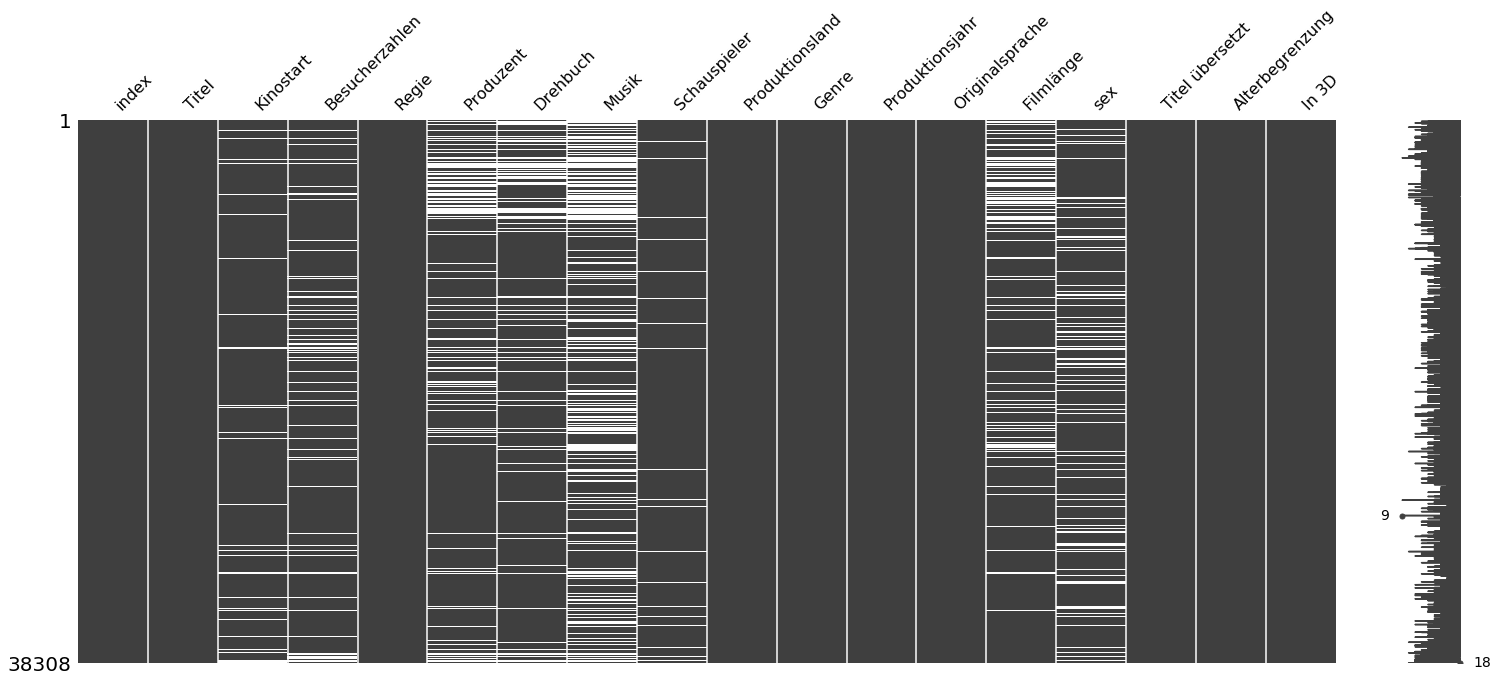

In [125]:
missingno.matrix(df_save[df_save.columns])
plt.show()

Hier sehen wir nochmals eine vorzügliche Übersicht über die fehlenden Daten im Datenset. Informationen über die Besucherzahlen, Produzent, Drehbuch, Musik, Filmlänge und das Geschlecht fehlen am meisten. Bei der weiteren Analyse muss darauf geachtet werden, dass zum Teil Informationen fehlen können.

#### 2.3.2 Seaborn pairplot

Durch einen Seaborn Pairplot wollten wir die einzelnen nummerische Spalten miteinander vergleichen und deren Relation analysieren. Dabei werden die Geschlechter in zwei verschiedenen Farben repräsentiert.

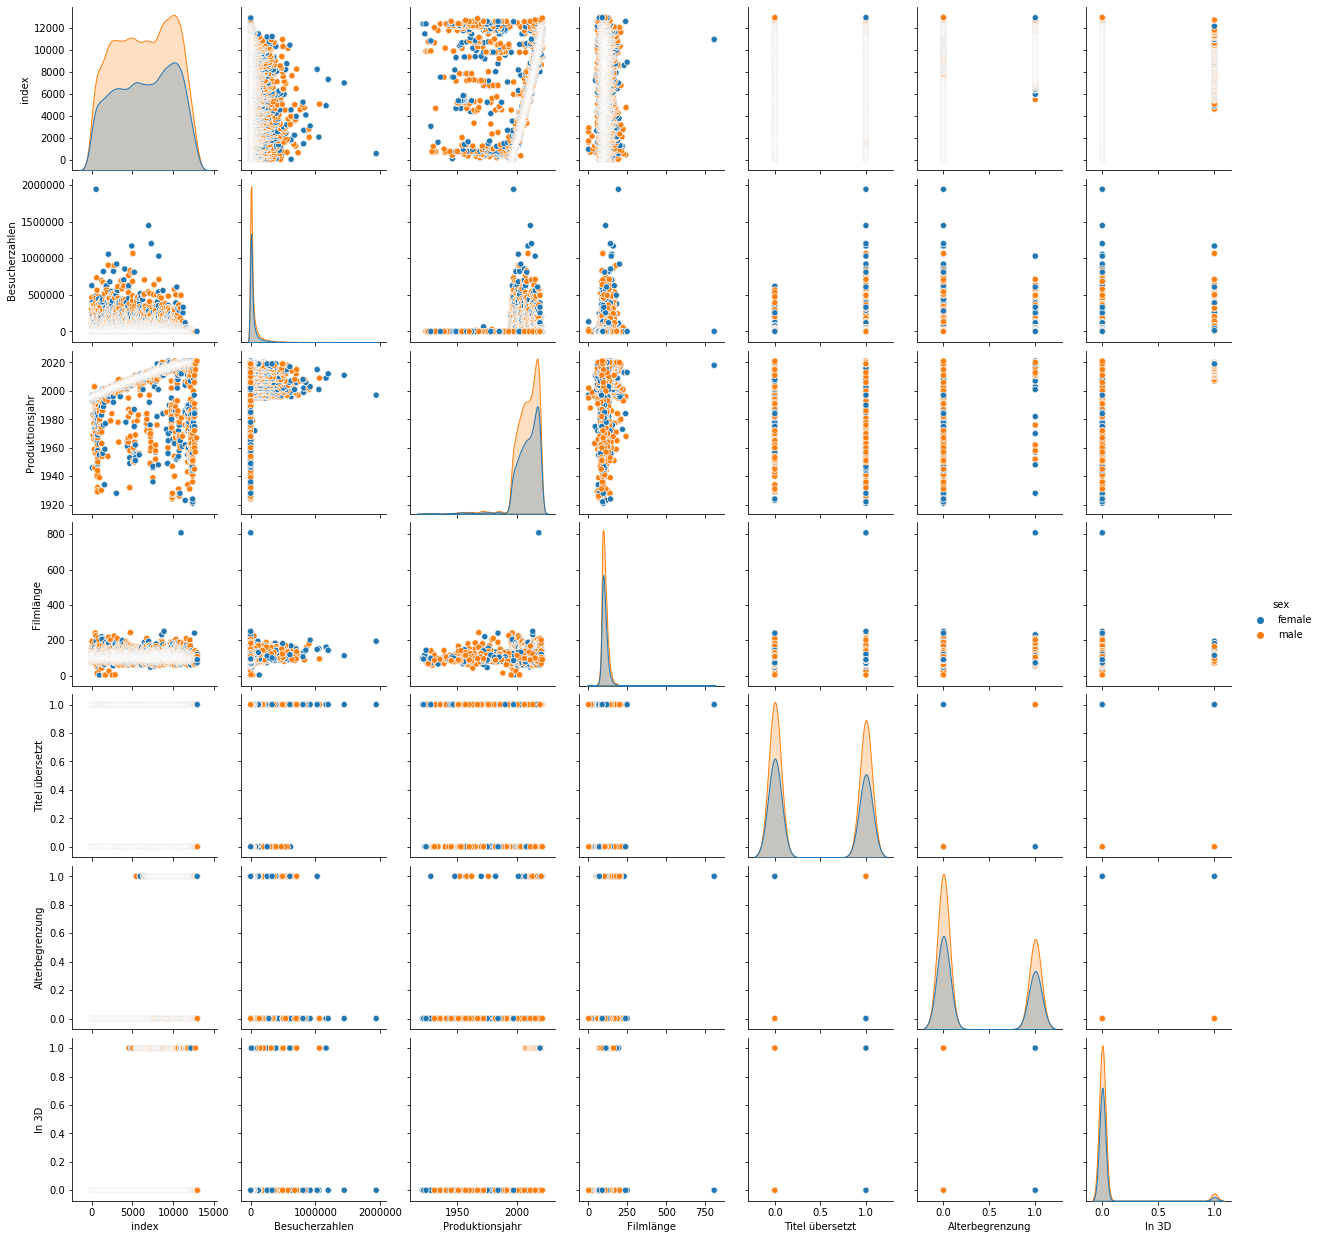

In [165]:
sns.pairplot(df_clean,hue="sex")
plt.show()

Dank der Analyse könne wir hier sehen, dass unter den vielen Charts einige Attributen nicht miteinander verglichen werden können, da die Relationen zueinander fehlen. Für die Netzwerkanalyse ist es sinnvoll diese Werte nicht miteinander zu vergleichen.

#### 2.3.3 Vergleich zwischen Schauspielern und Schauspielerinnen

In [193]:
#Float to int
df_clean['Produktionsjahr'] = df_clean['Produktionsjahr'].round().astype('Int64')
df_clean['Filmlänge'] = df_clean['Filmlänge'].round().astype('Int64')
df_clean['Besucherzahlen'] = df_clean['Besucherzahlen'].round().astype('Int64')

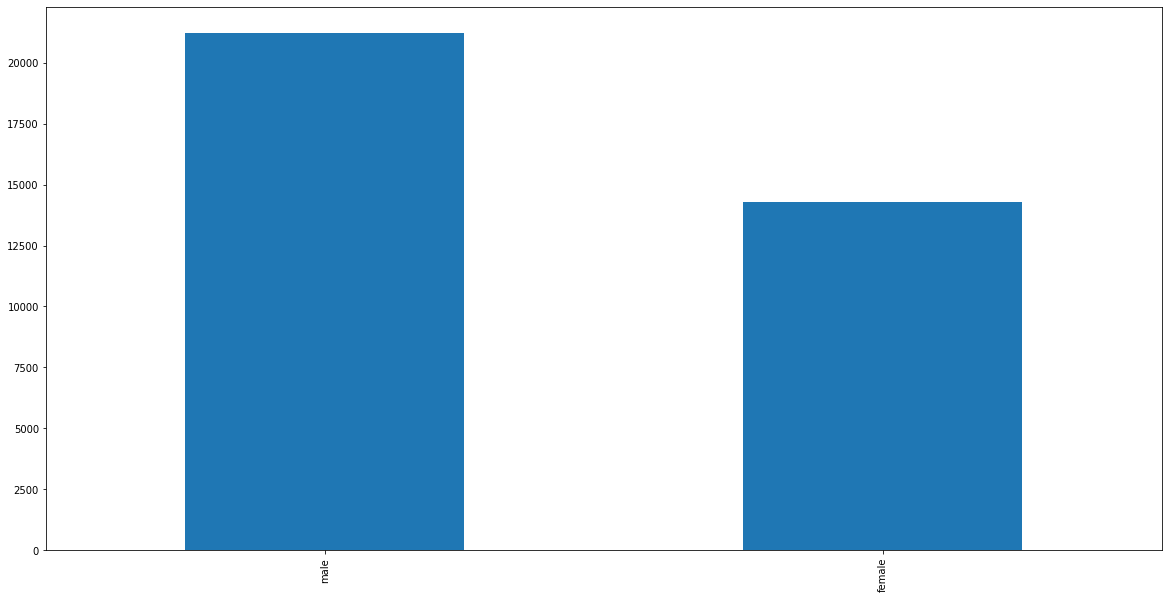

In [224]:
df_sex = df_clean.sex.value_counts().to_frame()
df_sex.plot.bar().get_legend().remove()
plt.show()

In der oberen Grafik können wir das Verhältnis der männlichen und weiblichen Schauspieler beobachten. Dabei fällt auf, dass es ca. 25 % mehr männliche Schauspieler hat wie weibliche.

#### 2.3.4 Genre Vergleich

Als nächstes möchten wir die einzelnen Genre analisieren. 

In [225]:
df_pi = df_clean.Genre.value_counts().to_frame()
#remove Genres, wo weniger als 1% sind
maxx = df_pi.max().tolist()[0]
min_value = maxx/100
df_pi = df_pi[df_pi['Genre']  > min_value]  

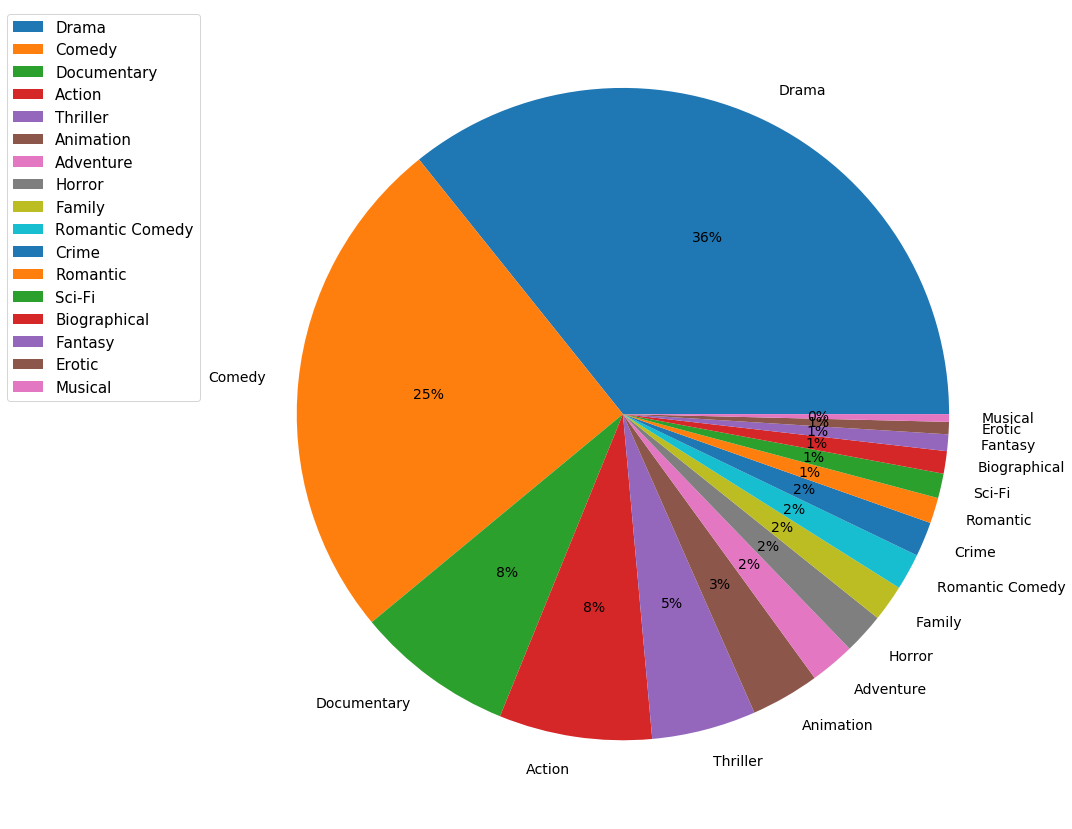

In [226]:
df_pi.plot.pie(y='Genre', figsize=(15, 15),autopct='%1.0f%%',fontsize=14)
plt.legend(bbox_to_anchor=(-0.01, 1),fontsize=15)
plt.ylabel('')
plt.show()

Im Kuchendiagramm sehen wir die verschiedenen Genres und wie oft sie in der Datenbank vorkommen. Filme, die mit unseren Gefühlen gespielt werden (Drama und Comedy) werden am häufigsten in den Schweizer Kinos gezeigt.

#### 2.3.5 Verlauf der Besucherzahlen im Verlaufe der Jahre

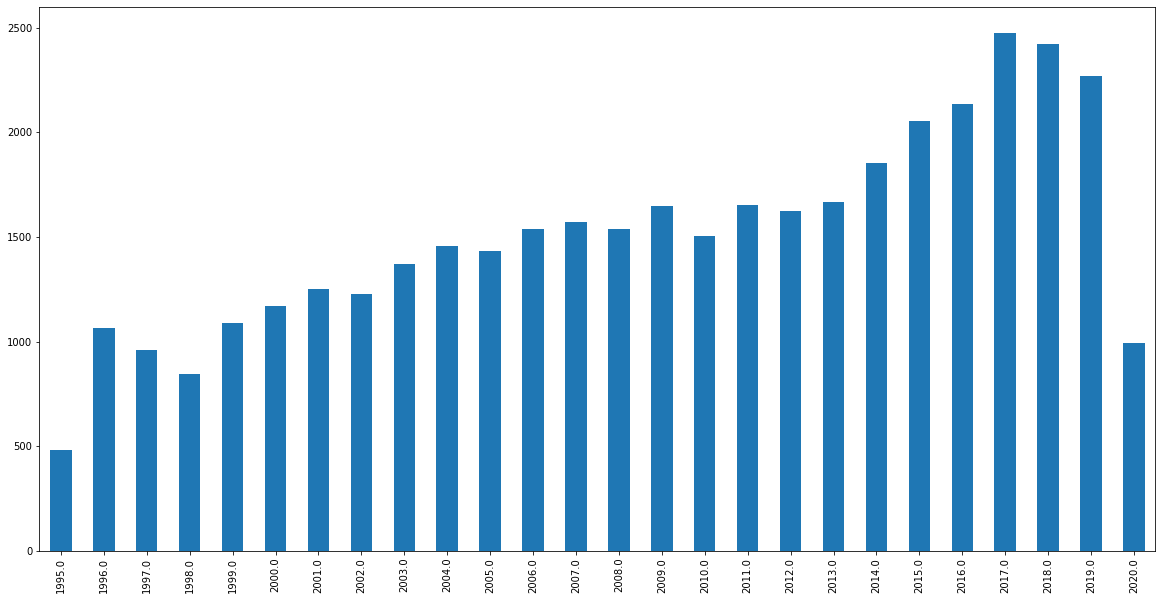

In [228]:
df_clean = df_clean[df_clean.Produktionsjahr >= 1995]
df_clean = df_clean[df_clean.Produktionsjahr <= 2020]
df_year = df_clean.Produktionsjahr.value_counts().to_frame()
df_year = df_year.sort_index()
df_year.plot.bar().get_legend().remove()
plt.show()

Die Anzahl gezeigten Filme nimmt trotz Netflix und co weiter stetig zu. Seit 1999 sind die Besucherzahlen noch nie so tief wie im Vorjahr gewesen. Hier ist es klar ersichtlich, dass im Corona-Jahr 2020 aufgrund der Lockdown-Massnahmen zu einem starken Rückgang der Filmvorführungen gekommen ist. 

## 3. Soziale Netzwerkanalyse

In [132]:
data_25_year = nx.read_gexf("../Gephi/Datenanalyse/25_year_one_connected.gexf")
data_25_year = nx.path_graph(data_25_year)
data_25_year = data_25_year.to_undirected()

Für unsere erste Analyse haben wir die Informationen über die Schauspielern/-innen und deren Filme über die letzten 25 Jahre genutzt. Die 25 Jahre gehen von 1995 bis und mit 2019. Da 2020 durch Corona zu einer Ausnahme mit den Zahlen wurde, wollten wir diese zur Analyse nicht berücksichtigen.

### 3.1 Communities im Netzwerk

Eine Community ist ein Subgraph innerhalb eines Graphen, in welchem die Knoten sehr stark untereinander verbunden sind. In unserem Fall wollen wir die Verbundenheit der einzelnen Schauspieler analysieren. Communities bilden sich meistens um einen Kontext herum, das heisst in unserem Bespiel um verschiedene Filme. Dort gibt es auch häufig Kernmitglieder und periphere Mitglieder, die eher weniger Beziehungen zu anderen aufweisen. Hier können wir herausfinden, welche/r Schauspieler/in am angesehensten in ihrer Community sind.

Als Connected Component wird eine Menge von Knoten verstanden, die über beliebige Pfade miteinander verbunden sind. Ist ein Teilnetzwerk abgeschnitten, bildet es einen zweiten Component. Von allen vorgestellten Verfahren zur Gruppenfindung in einem Graphen sind die Bedingungen für einen Connected Component am wenigsten einschränkend. 

Bei gerichteten Graphen wird zwischen Strongly Connected Component und Weakly Connected Component unterschieden. Bei beiden Connected Component Varianten befindet sich schlussendlich jeder Node genau in einem Component.
Ein Stronlgy Connected Components ist dadurch definiert, dass ich alle Knoten entlang der Kantenrichtung erreichen
Da es sich hier um einen ungerichteten Graphen handelt, können wir nicht überprüfen wie die Strongly-Connected Components aussehen.

#### 3.1.1 Weakly connected components

#### 3.1.2 Giant Component

Wenn ein Component einen signifikanten Teil der Knoten des Netzwerks enthält, wird dieser Giant Component genannt.
Bereits bei der ersten Visualisierung im Gephi können wir feststellen, dass sich im Datensatz ein Giant Component befindet. In der weiteren Analyse werden wir nun diesen Giant Component noch genauer analysieren. 

Eine Community zeigt, wie stark die Aktoren miteinander verbunden sind. Ebenfalls identifiziert die Analyse, welche Personen im Netzwerk gut miteinander verbunden sind und welche nicht, resp. welches das Kern-Netzwerk ist und welches die abgeschnittenen Teil-Netzwerke sind.

Falls der Graph aus mehreren Components besteht, kann dies dazu führen, dass Informationen nicht an alle Aktoren gelangen und der Informationsfluss ist nicht mehr gewährleistet werden kann. In unserem Fall bedeutet das jedoch, dass die einzelnen Communities nicht miteinander in Verbindung stehen. Schauspieler die nur über bestimmt Filme in Verbindung stehen haben keine Verbindung zu den anderen Schauspielern. Dieser Abbruch vom Informationsfluss kann entstehen, wenn zum Beispiel verschiedene Schauspieler nur in eine Sprache arbeiten. Dann können wir die verschiedenen Communities in den einzelnen Sprachen erkennen.


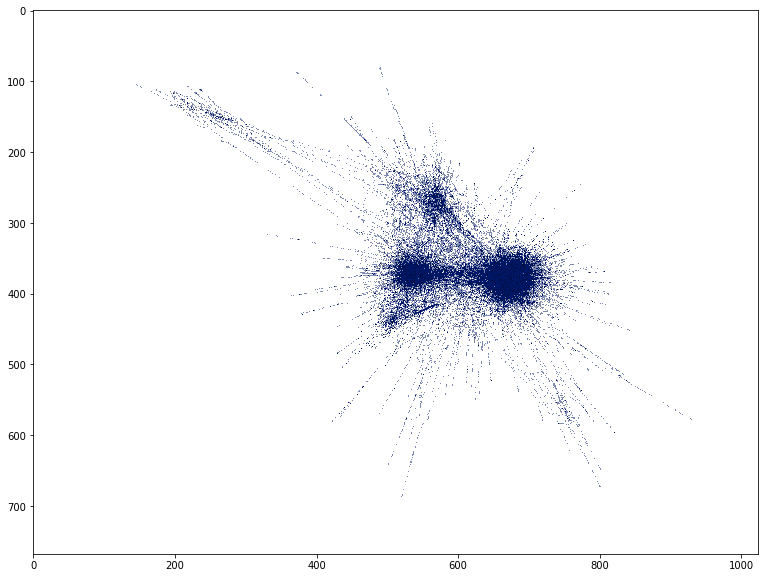

In [379]:
# Read Images
img = mpimg.imread('../Bilder/Giant_component.png')
  
# Output Images
plt.imshow(img)
plt.show()

In der oberen Grafik ist der Giant Component von unserer Datenbank zu sehen, hier vergleichen wir Schauspieler mit Titel.

#### 3.1.3 k-Core

Es gibt verschiedene Möglichkeiten, wie eine Community identifiziert werden kann, die unterschiedlich restriktiv sind. 
Der k-Core ist ein maximal grosser Subgraph, wobei jeder Knoten zu mindestens k andere Knoten des
Clusters verbunden sein muss. Bei einem k-Core haben alle Knoten in einer Gruppe mindestens k Links zu anderen Gruppenmitgliedern. Hier besteht nur ein gewisser Grad an Verbundenheit.

Um herauszufinden wie die Verbundenheit der Knoten steht, haben wir im Gephi den k-Core Filter eingesetzt. Dabei haben wir herausgefunden, dass die Knoten dieser Graph maximal 3 Links zu anderen Gruppenmitgliedern haben. Den Graph haben wir zusätzlich in den einzelnen Modularity-Klassen eingefärbt. 

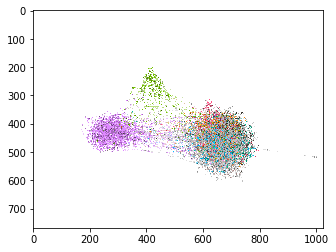

In [2]:
# Read Images
img = mpimg.imread('../Bilder/3-Core-Modularity einfärbung.png')
  
# Output Images
plt.imshow(img)
plt.show()

Durch die Einfärbung können wir sehen, dass die ersten zwei Modularity-Klassen eine Gemeinschaft bilden, die mindestens drei Links zu anderen Knoten aufweisen. 

#### 3.1.4 Modularity based clustering

Der in Gephi implementierte Modularitätsalgorithmus sucht nach den Knoten, die dichter miteinander verbunden sind als mit dem Rest des Netzwerks.

Wenn man diese Berechnung implementieren, zeigen die Farben verschiedene Communities an, die von diesem Algorithmus bestimmt werden. Im Grunde zeigen sie an, welche Schauspieler dichter miteinander verbunden sind als mit dem Rest des Netzwerks.

Um diese Informationen hilfreich zu machen, müssen man jedoch mit mindestens einem weiteren Takt vergleichen. Wenn man beispielsweise die Betweenness Centrality-Messung anwenden, welches zeigt wie die unterschiedlichsten Communities miteinander verbinden oder die einflussreichsten Knoten im Netzwerk als Knotenpunkte dienen, kann man die anfälligsten Beziehungen in jeder Community identifizieren. 

Mit Hilfe der höchsten Grad kann man auch eine Community herausfiltern und die am meisten verbundenen Router innerhalb jeder Community identifizieren. Alles in allem ermöglicht uns die Modularitätsmessung, Schwachstellen eines Netzwerks zu erkennen und einen Überblick über dessen Struktur zu erhalten.


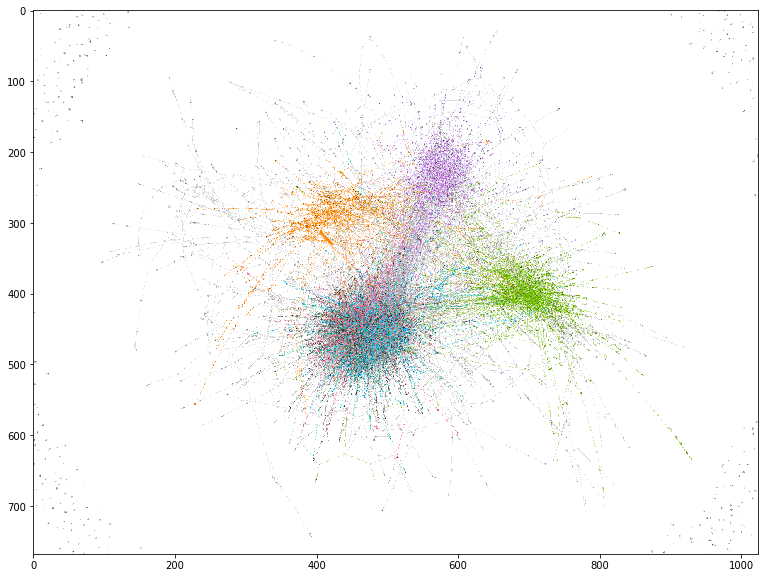

In [137]:
img = mpimg.imread('../Bilder/Modularity_Class.png')
plt.imshow(img)
plt.show()

Hier haben wir die Modularity-Class für den ganzen Datensatz angewendet. Anhand der Modularity-Class können wir vier eindeutige Klassen erkennen.

Als einen weiteren Schritt haben wir nur die ersten drei Modularity-Class Groupen filtriert.

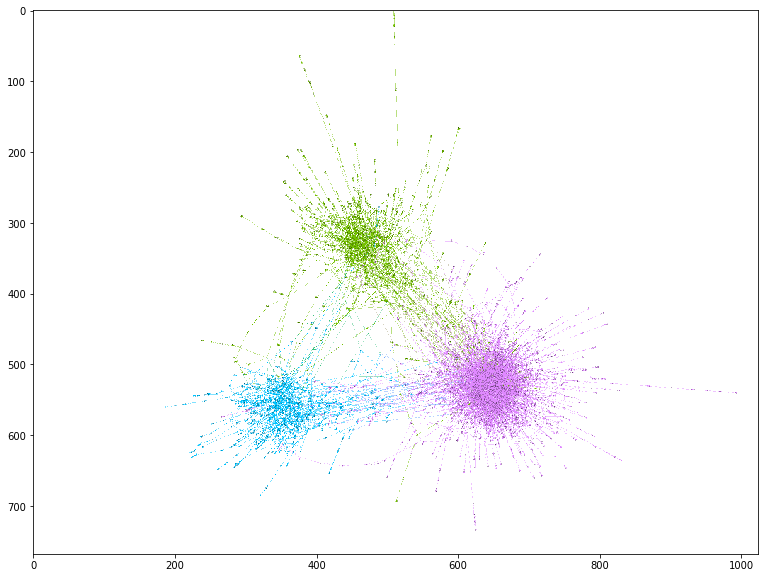

In [138]:
img = mpimg.imread('../Bilder/Modularity-25.png')
plt.imshow(img)
plt.show()

#### 3.1.5 Two-Mode to One-Mode Projections (Test)

In einem Multirelationalen Netzwerk werden mehrere Beziehungstypen im selben Netzwerk abgebildet (in unserem Fall Filme und Schauspieler). Für eine genauere Analyse ist es erforderlich, die Relationstypen zu reduzieren. Aus diesem Grund haben wir als Beispiel das Jahr 2015 genommen und die Two-Mode Projection in eine One-Mode geändert. 
Jedoch ist es interessant, aus einem ursprünglichen multirelationalen Netzwerk verschiedene Netzwerke mit unterschiedlichen Relationstypen zu extrahieren und die Analysen dieser einzelnen Subnetzwerke wieder miteinander zu vergleichen. Bei Two-Mode Netzwerken existieren im Gegensatz zu den One-Node Netzwerken zwei verschiedene Typen von Knoten. Kanten existieren nur zwischen Knoten verschiedener Typen (auch Bipartites Netzwerk genannt). 
Interessant ist, dass die Anzahl Kanten eines Knotens angeben, wie viele Verbindungen zum anderen Knotentyp bestehen unter der Voraussetzung, dass keine parallelen Kanten existieren. Das One-Mode Netzwerk können nicht ohne Anpassung auf ein Two-Mode Netzwerk angewendet werden. Ein Two-Mode Netzwerk lässt sich jedoch in ein One-Mode Netzwerk transformieren. Es gibt es verschiedene Möglichkeiten für eine solche Transformation.


Hier haben wir uns für die Filmdaten des Jahres 2015 geholt und diese in eine One-Mode Netzwerk geändert. 

In [139]:
data_2015 = nx.read_gexf("../Gephi/Datenanalyse/2015.gexf")

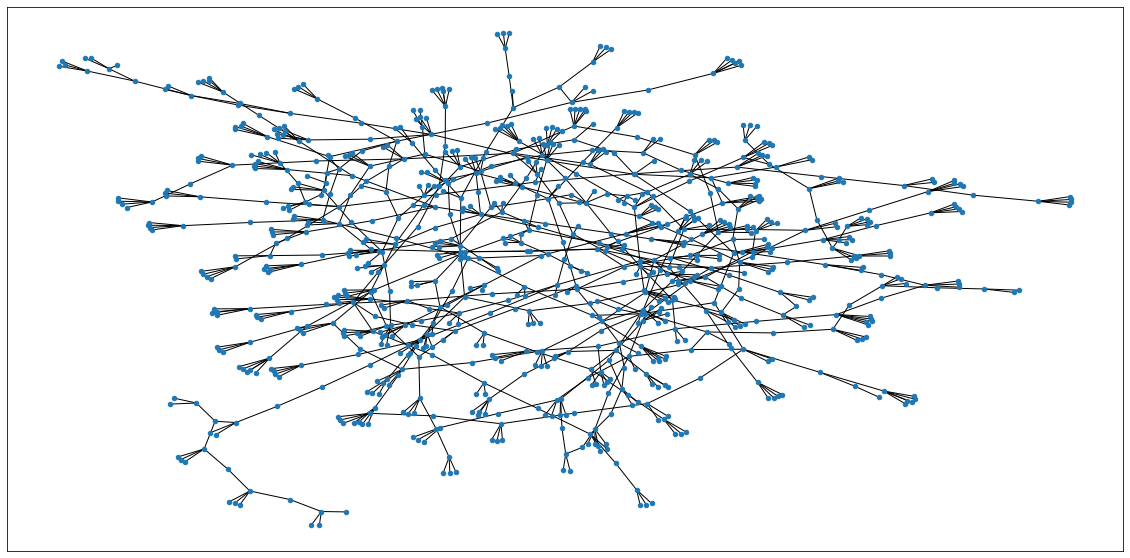

In [140]:
nx.draw_networkx(data_2015, node_size = 20, with_labels=False)

In [141]:
print(f"Is the graph bipartite? {nx.is_bipartite(data_2015)}")

Is the graph bipartite? True


Durch eine einfachen Transformation werden im resultierenden Netzwerk alle Knoten eines Typ A miteinander verbunden, welche zu gemeinsamen Knoten des Typ B eine Kante haben.

In [142]:
first_group, second_group = bipartite.sets(data_2015)
pos = nx.drawing.layout.spring_layout(data_2015, seed = 42)
def draw_emphasizing_edge_weight(G):
    pos = nx.drawing.layout.spring_layout(G, seed = 42)
                                                                                                      
    nx.draw_networkx_nodes(G, pos, node_color="lightblue")                                                                                                        
    nx.draw_networkx_labels(G, pos, font_size=15, font_family='sans-serif')

    for edge in G.edges(data='weight'):
        nx.draw_networkx_edges(G, pos, edgelist=[edge], width=edge[2])
    
simple_projection = bipartite.projected_graph(data_2015, first_group)

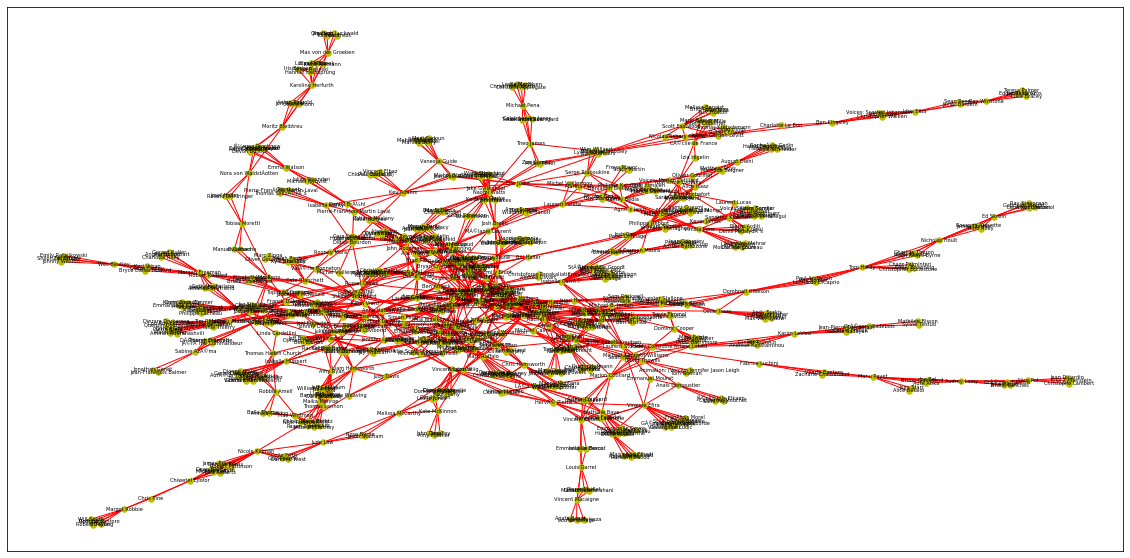

In [143]:
nx.draw_networkx(simple_projection,node_size = 30,font_size = 5,node_color= "y", edge_color="r")

### 3.2 Centrality in networks

#### 3.2.1 Degree Centrality

Die Degree Centrality ist ein sehr einfaches Zentralitätsmass. Es zählt die Anzahl Kanten, die von einem Knoten weg gehen oder zu einem Knoten führen. Die Summe dieser Kanten bildet dann den Degree des Knotens. Die Degree Centrality kann als lokales Mass angesehen werden. Es sagt nichts über das komplette Netzwerk aus, sondern bietet lediglich eine isolierte Sicht auf einen Knoten. 

Hier haben wir die Schauspieler gefunden, die einen hohen Degree-Wert besitzen.

In [9]:
df_25 = pd.read_csv ('../data/gephi_25_year_all.csv',low_memory=False)

In [10]:
#clean imported data
translations = {'Ã©': 'é','Ã¼': 'ü','Ã¶': 'ö','Ã¤': 'ä','Ã„': 'Ä','Ã–': 'Ö','Ãœ': 'Ü'}
df_25.replace(translations, inplace=True, regex=True)

In [11]:
df_25.sort_values(by=['Degree'], ascending=False)[['Id', 'Degree']].head()

,Id,Degree
0,Gérard Depardieu,55
1,Samuel L. Jackson,43
2,Nicole Kidman,42
3,Julianne Moore,41
4,Karin Viard,40


Ein Aktor mit einem hohen Degree-Wert geniesst eine hohe Wahrnehmung und Einfluss. Er ist im Netzwerk sehr prominent. Solche Personen eignen sich, um Informationen zu verbreiten oder andere direkt zu beeinflussen. Ein hoher Degree-Wert bedeutet meistens auch eine hohe Aktivität. Hat ein Aktor sehr viele Indegrees, gibt es auch viele Wege, über welche er informiert werden kann. 
In unserem Fall sind diese Schauspieler, sehr bekannte Persönlichkeiten, die aktiv in verschiedenen Filmen mitgemacht haben. Ihre Degree Wert zeigt, dass sie über diese 25 Jahren in zahlreichen Filmen mitgespielt haben, welche in der Schweiz aufgeführt worden sind.

#### 3.2.2 Closeness Centrality

Die Closeness Centrality berechnet für jeden Knoten, wie effizient von diesem Knoten aus alle anderen Knoten erreichbar sind. Die Closeness Centrality für einen Knoten berechnet sich durch die Summierung aller Inversen der kürzesten Distanzen zu allen anderen Knoten. Nun werden wir die Closeness Centrality der einzelnen Filmen in den 25 Jahren berechnen.

In [12]:
df_25.sort_values(by=['closnesscentrality'], ascending=False)[['Id', 'closnesscentrality']].head()

,Id,closnesscentrality
7359,Chico & Rita,1.0
12400,Ok jaanu,1.0
12584,Triple agent,1.0
15962,La vida es silbar,1.0
12571,Il Voto e segreto,1.0


Ein Aktor mit hoher Closeness Centrality kann alle anderen Knoten im Netzwerk effizient erreichen. Es kann als Mass für die sequenzielle Verbreitung von Informationen ausgehend von einem Knoten interpretiert werden, indem immer die kürzesten Pfade berücksichtigt werden. Unsere fünf Filme mit den max. höchsten Closnesscentrality Werte sind nicht die effizientesten im Netzwerk. Diese Filme haben nur einen hohen Wert, weil sie eigene Gruppen bilden, die nicht mit dem Rest des Netzwerkes verbunden sind.

#### 3.2.3 Betweenness Centrality

Die Betweenness Centrality untersucht die Position eines Knotens unter Berücksichtigung des kompletten Netzwerkes.  Sie berechnet für jeden Knoten, wie stark sich dieser in einer Brokerage Position befindet. Dazu wird von jedem Knoten der kürzeste Pfad zu allen anderen Knoten berechnet. Für jeden Knoten wird gezählt, wie häufig dieser auf kürzesten Pfaden liegt. Je häufiger dies der Fall ist, desto grösser seine Betweenness Centrality.

Ein Aktor mit hohem Betweenness Centrality spielt eine zentrale Rolle, weil ein grosser Teil der Kommunikation des Netzwerks über diesen Knoten verläuft. Er hat auch die Möglichkeit, den Informationsfluss zu beeinflussen, indem er die Weiterleitung von Nachrichten verhindert oder fördert. Er kann die Nachrichten auch manipulieren oder Profit aus den Informationen schlagen. Aktoren mit einem hohen Betweenness Wert stellen zudem einen kritischen Punkt im Netzwerk dar, deren Ausfall die Gesamt-Kommunikation des Netzwerks markant beeinflussen kann.

In [13]:
df_25.sort_values(by=['betweenesscentrality'], ascending=False)[['Id', 'betweenesscentrality']].head()

,Id,betweenesscentrality
9,Moritz Bleibtreu,0.023319
0,Gérard Depardieu,0.022168
29,Bruno Ganz,0.017873
32,Monica Bellucci,0.016664
59,Daniel Brühl,0.013356


Hier sehen wir fünf dieser Schauspieler/-innen die einen hohen Betweenness Centrality geniessen.

##### Nachteil der Centrality Analysen

Die vorangehend erläuterte Degree, Closeness und Betweeness - Centrality lassen sich leicht berechnen. Ein Schwachpunkt ist jedoch, dass es sich lediglich um ein lokales Mass handelt. Sie betrachten nur gerade die adjazenten Knoten und nicht das komplette Netzwerk. Möglicherweise ist es aber nicht wichtig, sehr viele direkte Kontakte zu besitzen, sondern nicht zu weit vom Zentrum entfernt zu sein.
In unserem Beispiel könnte es heissen, dass es nicht wichtig ist in mehreren Filmen mitgespielt zu haben, sondern in wichtigen, erfolgreichen Filmen.

### 3.3 Soziale Netzwerkanalyse

Die Aktor Zentralitäten berechnen, wie zentral ein Aktor anhand lokaler Gegebenheiten oder seiner Position innerhalb des Netzwerks ist. Die Netzwerk-Zentralisierung kombiniert alle Aktor Zentralitäts-Werte zu einem einzelnen Wert der
aussagt, wie gross die Ungleichheit der Aktor Zentralitäts-Werte innerhalb des Netzwerkes sind. 

Für diese Analyse nehmen wir wieder die Daten der letzten 25 Jahre.

In [149]:
df = pd.read_csv ('../data/gephi_25_year_all.csv',low_memory=False)

#### 3.3.1 Degree Zentralisierung

In [150]:
degreecentrality = list(df["Degree"])
degree_list = []
for node in degreecentrality:
    maxi = max(degreecentrality)
    degree_list.append(maxi-node)
    
degree_zentralität = sum(degree_list)/((len(degree_list)-1)*(len(degree_list)-2))
degree_zentralität

0.0018864772328300791

#### 3.3.2 Betweenness Zentralisierung

In [151]:
betweennesscentrality = list(df["betweenesscentrality"])
betweeness_list = []
for node in betweennesscentrality:
    maxi = max(betweennesscentrality)
    betweeness_list.append(maxi-node)  
    
betweeness_zentralität = sum(betweeness_list)/(len(betweeness_list)-1)
betweeness_zentralität

0.023162086608790638

#### 3.3.3 Closeness Zentralisierung

In [152]:
closenesscentrality = list(df["closnesscentrality"])
closeness_list = []
for node in closenesscentrality:
    maxi = max(closenesscentrality)
    closeness_list.append(maxi-node)  
    
closness_zentralität = sum(closeness_list)/((len(closeness_list)-2)/2)
closness_zentralität

1.4788664621704637

#### 3.3.4 Density (Dichte) 

Die Graph Density beschreibt, wie komplett die Aktoren eines Graphen miteinander verbunden sind. Der Density-Wert liegt immer im Bereich zwischen 0 und 1. Der Density-Wert 0 steht für einen Graphen, in dem es gar keine Kanten gibt. Der Density-Wert 1 beschreibt einen Graphen, bei dem alle Knoten mit allen anderen Knoten verbunden sind. In der Graphentheorie wird dies auch als Kompletter Graph oder Clique bezeichnet. 

Die Dichte ist häufig ein Indikator, wie schnell sich Informationen in einem Netzwerk verbreiten. In einem dichten Netzwerk verläuft die Kommunikation sehr direkt. Mit steigender Anzahl der Knoten in einem grossen Netzwerk steigt auch die Anzahl der möglichen Kanten. Die Anzahl direkter Kontakte von Personen bleiben aber ungefähr konstant. Deshalb nimmt die Dichte mit der Grösse des Netzwerks ab. Dies ist auch ein Problem, wenn die Dichte verschiedener Netzwerke miteinander vergleichen werden. Die Dichte gibt auch Auskunft über den Zusammenhalt eines Netzwerks, resp. einer Subnetzwerkes, wenn nur ein Teil des Netzwerks untersucht wird.


In [153]:
print(f"Density: {nx.density(simple_projection)}")

Density: 0.007380302654428182


Wir haben eine Dichte von 0.007 erhalten und gehen davon aus, dass die Aktoren im Netzwerk sehr schwach miteinander verbunden sind.

#### 3.3.5 Cluster Coefficient global

Der Cluster Coefficient ist ein Mass für Cliquenbildung in einem Graphen. Ein Wert von 1 bedeutet dabei, dass es sich um eine Clique handelt. Es wird zwischen dem lokalen und dem globalen Cluster Coeffcient unterschieden, wobei es sich beim globalen Wert um den Mittelwert der lokalen Werte handelt. Der lokale Cluster Coefficient berechnet sich aus dem Quotienten der Anzahl direkten Kanten zwischen den Nachbarn eines Knoten. Bei ungerichteten Netzwerken wie bei uns multipliziert man mit dem Faktor 2 und der maximal möglichen Anzahl direkter Kanten.

In [154]:
print("Clustering Coefficients of all nodes:")
cluster = nx.clustering(simple_projection)
for x in list(cluster)[0:10]:
    print ("key: {}, value: {} ".format(x,  cluster[x]))

Clustering Coefficients of all nodes:
key: Scott Haze, value: 1.0 
key: Toby Kebbell, value: 0.42857142857142855 
key: Jeff Goldblum, value: 1.0 
key: Marc Zinga, value: 1.0 
key: Robert De Niro, value: 0.42857142857142855 
key: Jai Courtney, value: 1.0 
key: Eva Kuen, value: 1.0 
key: Melissa Leo, value: 1.0 
key: Niels Arestrup, value: 1.0 
key: John Goodman, value: 0.4444444444444444 


Akteure mit einem hohen Clustering Coeffitienten sind stark lokal vernetzt und haben möglicherweise aufgrund längerer oder intensiverer Kontakte geschlossene Triaden gebildet. Stark vernetzte Gruppen haben häuffig gemeinsame Interessen und Wertvorstellungen. Bei unseren Netzwerk handelt es sich um Schauspieler/innen, die stark mit einander verbunden sind. Diese Verbindung entsteht durch die gemeinsame Filme und Film-Kollegen.

#### 3.3.6 Node Connectivity

Bei der Graph Connectivity wird untersucht, wie viele Elemente wie Knoten oder Kanten entfernt werden müssen, damit der Graph nicht mehr verbunden ist. Damit kann untersucht werden, wie anfällig ein Netzwerk auf Ausfälle von Knoten oder Kanten ist. Um eine Aussage über die Verbundenheit eines Graphes zu machen, gibt es verschiedene Gesichtspunkte, welche untersucht werden können.

In [155]:
nx.is_k_edge_connected(simple_projection, 1)

True

In [156]:
nx.is_k_edge_connected(simple_projection, 2)

False

Hier sehen wir, dass bei einer Entfernung von 2 Elementen der Graph schon nicht mehr verbunden ist.

### 3.4 Statistik in Netzwerken

In [375]:
df = pd.read_csv ('../data/25_year.csv',low_memory=False)

In [376]:
encode_cols = df.drop(['Titel', 'Schauspieler','Kinostart'], axis=1)
categorical_features = encode_cols.select_dtypes(include='object').columns.to_list()
print('Categorical Features: ', categorical_features)

Categorical Features:  ['Regie', 'Produzent', 'Drehbuch', 'Musik', 'Produktionsland', 'Genre', 'Originalsprache', 'sex']


In [377]:
count_encodings = {}
for col in categorical_features:
    group = df.groupby(by=col).count().iloc[:,0]
    count_encodings[col] = dict(zip(group.index.to_list(), group.values))
for col in categorical_features:
    print('Currently processing..', col)
    df[col] = df[col].replace(count_encodings[col])

Currently processing.. Regie
Currently processing.. Produzent
Currently processing.. Drehbuch
Currently processing.. Musik
Currently processing.. Produktionsland
Currently processing.. Genre
Currently processing.. Originalsprache
Currently processing.. sex


#### 3.4.1 Spearman Korrelation

Die Spearman Korrelation misst, ob der Zusammenhang zwischen zwei Variablen einer monoton steigenden Funktion entspricht. Dies bedeutet, dass f(x) immer dann wächst, wenn x erhöht wird.

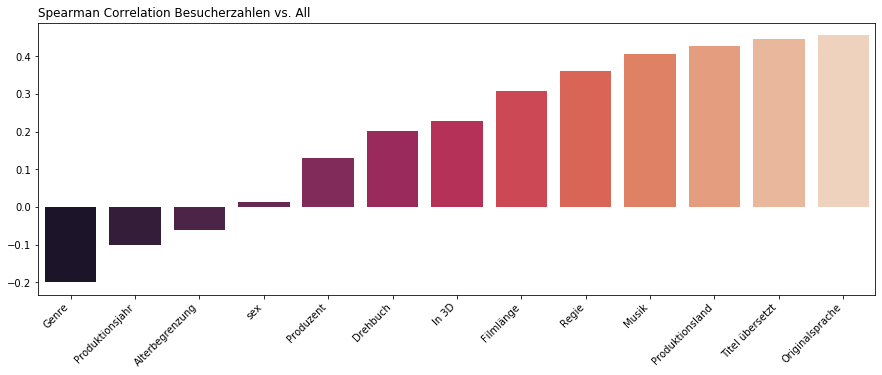

In [378]:
tmp = df
tmp = tmp.corr(method='spearman')['Besucherzahlen'].drop(['index'])
tmp = tmp[~tmp.index.isin(['Besucherzahlen'])]
fig, ax = plt.subplots(1,1, figsize=(15,5))
p = sns.barplot(x=tmp.index, y=tmp.values, order=tmp.sort_values().index, palette='rocket')
p.set_xticklabels(p.get_xticklabels(), rotation=45,
                 horizontalalignment='right')
p.set_title('Spearman Correlation Besucherzahlen vs. All', loc='left')
plt.show()

In der oberen Grafik ist eine Spearman Korrelation von Besucherzahlen zu sehen. Ist der Wert um 0 herum, bedeutet das, dass dieser Attribute keine grosse Veränderung zu unserer Zielvariable ausüben. Somit lässt sich aus dem Diagramm ablesen, dass die Sprache grössten Einfluss auf die Besucherzahlen hat. Dies macht in unseren Augen natürlich Sinn, weil auch zum Beispiel auf Deutsch oder Englisch, dass die meisten Zuschauer ansprechen in der Schweiz.

### 3.4 Im Meilenstein definierte Analysen

#### Frage: Mit wie vielen Schauspielern hat ein Schauspieler durchschnittlich gespielt? 
- Filterung:
    - Für diese Analyse brauchen wir nur die Angaben von den Schauspielern und die von ihnen gespielte Filmtitel. 
- Analyse:
    - Um diesen Durchschnitt zu berechnen, werden wir Python nutzen und den Mittelwert ausrechnen lassen.
- Erwartung:
    - Es wird erwartet, dass ein/e Schauspieler/in mindestens mit zwei weiteren Personen gespielt haben wird. Als einen Maximalwer setzten wir bei 4 Personen an, weil meistens nur die Hauptfiguren aufgelistet werden und nie alle Schauspieler.
- Vorgehen:
    - Wir analisieren, welche Schauspieler/innen bei den meisten Filmen mitgemacht haben. Auf Grund der vielen Projekten sind sie sicher auch am meisten mit anderen Personen in Kontakt gekommen. Deshalb werden wir diese Personen und deren Beziehung zueinander genauer analysieren. 

In [243]:
df_Titel = df_clean.Titel.value_counts().to_frame()
mean_Schauspieler = df_Titel["Titel"].mean()-1
print("Ergebniss:",mean_Schauspieler)

Ergebniss: 2.438106902283265


- Interpretation:
    - Im Schnitt spielt ein Schauspieler mit 2-3 anderen Schauspielern in einem Film. Es hat sich ergeben. dass unsere Vermutung gestummen hat. In Wirklichkeit haben die Schauspieler sicher mit mehreren Personen gearbeitet, jedoch verfügen wir nicht über diese Informationen. Aus diesem Grund gehen wir davon aus, dass ein/e Schauspieler/in mindestens mit zwei weiteren bekannten Schauspieler/in tätig war.

#### Frage: Welcher Regisseur hat bei den meisten Filmen Regie geführt?
- Filterung: 
    - Für diese Analyse nehmen wir die Daten zur Regie und Filmtitel. 
- Analyse:
    - Wir werden in Python und in Gephi die Analyse erstellen und auflisten welche Regiseure bei den meisten Filmen Regie geführt haben. Hierfür werden wir rechnen, wie viele Filme pro Regisseur zugeteilt werden.
- Erwartung:
    - Wir haben keine Erwartung für diese Frage und werden uns von der Resultat überraschen lassen.
- Vorgehen:
    - Wir filtern zuerst alle Filme die doppelt vorkommen, weil immer nur ein Regisseur pro Film existiert. Dannach gruppieren wir die Regisseure und bekommen eine Auflistung, wie viele Filme ein Regisseur geführt hat.

In [255]:
df_regie = df_clean.drop_duplicates(subset=['Titel'])
df_regie = df_regie.Regie.value_counts().to_frame()
print("Ergebnisse:")
df_regie.head()

Ergebnisse:


,Regie
Woody Allen,25
Clint Eastwood,20
Ron Howard,17
Steven Spielberg,17
Neri Parenti,17


Um unsere Analyse zu überprüfen, haben wir in Gephi die Daten noch visuel darstellen lassen.

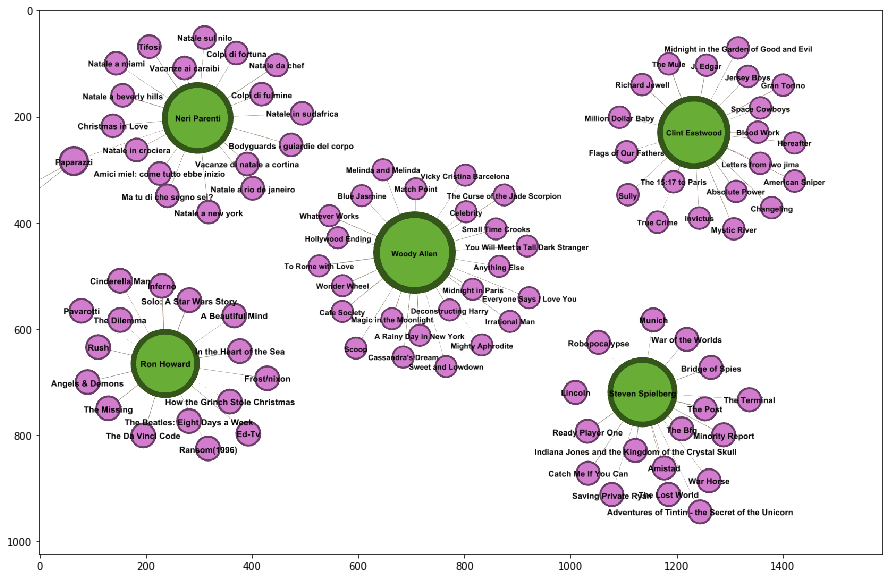

In [6]:
# Read Images
img = mpimg.imread('../Bilder/Regie_Film.png')
  
# Output Images
plt.imshow(img)
plt.show()

- Interpretation:
    - Wir können hier sehen, dass Woody Allen in den meisten FIlmen in dieser Zeit gewirkt hat. Sein Nachfolger Clint Eastwood hat bei 20 Filmen die Regie geführt. 


#### Frage: Welche Filme wurden am meisten besucht und wessen Schauspieler waren diese?
- Filterung:
    - Wir werden diese Analyse gleich in Python durchführen und dabei nur die Daten zur Bersucherzahlen genauer beobachten. Anschliessend werden wir die Informationen zu den Schauspielern hinzufügen.
- Analyse:
    - Durch eine Auflistung mit den meistbesuchten Filmen, können wir identifizieren, welche Filme am beliebtesten waren. Anhand dieser Liste können wir dann überprüfen, ob es gewisse Star-Schauspieler/innen in den letzten 25 Jahren gab, die viele Zuschauen gelockt haben.
- Erwartung:
    - Wir denken, dass es sicher Starschauspieler/innen geben wir, die einen gewissen Fan-Base besitzen. In solchen Fällen kann eine erhöhte Besucherzahl erwartet werden.
- Vorgehen:
    - Zuerst wird wieder darauf geachtet, dass der Film nur einmal vorkommt, weil die Besucherzahlen pro Film dieselben sind. Parallel müssen alle Schauspieler gruppiert werden, die im selben Film mitspielen. Anschliessend kann man die Filme mit den sortierten Besucherzahlen auflisten und mit der Liste der Schauspieler ergänzen.

In [289]:
df_besucher = df_clean.drop_duplicates(subset=['Titel'])
df_besucher = df_besucher.sort_values(by=['Besucherzahlen'], ascending=False)
df_besucher = df_besucher[["Titel","Besucherzahlen"]]
list_schauspieler = df_clean.groupby(['Titel'])['Schauspieler'].apply(list)
print("Ergebnisse:")
pd.merge(df_besucher, list_schauspieler, on='Titel').head()

Ergebnisse:


,Titel,Besucherzahlen,Schauspieler
0,Titanic,1940840.0,"[Leonardo DiCaprio, Kate Winslet, Bill Paxton,..."
1,Intouchables,1446377.0,"[François Cluzet, Omar Sy, Audrey Fleurot]"
2,Skyfall,1199248.0,"[Daniel Craig, Javier Bardem, Ralph Fiennes, J..."
3,Avatar,1166796.0,"[Sam Worthington, Sigourney Weaver, Zoe Saldan..."
4,Finding Nemo,1115846.0,[nan]


- Interpretation
    - Die Filme mit den hohen Besucherzahlen sind alles Filme, die für jeden bekannt sein sollten. Dies ist ebenfalls bei uns so der Fall. Die aufgelisteten Filme sind unterschiedlich, weshalb auch die Schauspieler nicht die gleichen sein werden. Beim Film "Findet Nemo" gibt es keine Schauspieler, weil es ein Animationsfilm ist. Anhand dieser Liste können wir bestätigen, dass Star-Schauspieler wie Leonardo DiCaprio oder Daniel Craig sicher viele Besucher angelockt haben.

#### Frage: Wer sind die produktivsten Schauspieler und in welchen Genres haben sie am meisten gespielt?
- These / Frage:	
    - Wer ist die produktivsten Schauspieler und in welchen Genres haben sie am meisten gespielt?
- Filterung:
    - Für diese Analyse werden für die Schauspielern mit dem Genre vergleichen. Bevor wir diese Analyse machen können, müssen wir die Schauspieler filtrieren. Aus diesem Grund haben wir die produktiven Schauspieler mit den meisten Filmen filtriert. Mit diesen Schauspielern werden wir analysieren in welchen Genres sie am meisten gespielt haben.
- Analyse:	
    - Wir wollen sehen, wer die meisten Filme dreht und was dabei die Genres dieser Filme ist.
- Erwartung:	
    - Bei den ersten Analysen hat sich ergeben, dass Drama, Comedy und Action einer das beliebteste Genre sind. Aus diesem Grund gehen wir davon aus, dass auch dieses Genre von den produktivsten Schauspielern gespielt wird.
- Vorgehen:
    - Als erster werden die Genres One-Hot-Encoded.
    - Danach werden die Schauspieler gruppiert und nach Anzahl Filmen, die sie mitgespielt haben, sortiert.
    - Anschliessend werden auch die einzelnen Genres zusammengezählt pro Schauspiele.
    - Zu Letzt werden beide Dataframe zusammengeführt.

In [355]:
df_genre_dummy = pd.get_dummies(df_clean.Genre)
df_genre = pd.concat([df_clean, df_genre_dummy], axis=1)
df_pi = df_clean.Genre.value_counts().to_frame()
df_genre_sum = df_genre.groupby(['Schauspieler']).sum()
df_genre_sum = df_genre_sum.iloc[:,-len(df_pi):]
df_spieler = df_clean.Schauspieler.value_counts().to_frame()
df_spieler = df_spieler.sort_values(by=['Schauspieler'], ascending=False)
df_spieler = df_spieler.rename(columns={"Schauspieler": "Total"})
print("Ergebnisse:")
pd.concat([df_spieler, df_genre_sum], axis=1).head()

Ergebnisse:


,Total,Action,Adventure,Animation,Biographical,Black Humor,Comedy,Comic Book,Crime,Documentary,Drama,Erotic,Family,Fantasy,Gay and Lesbian,Horror,Martial Arts,Musical,Period,Road Movie,Romantic,Romantic Comedy,Sci-Fi,Spoof,Sport,Spy,Teenage,Thriller,War,Western
Gérard Depardieu,57,2,4,0,1,0,22,0,1,0,24,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
Samuel L. Jackson,43,16,2,3,0,0,1,0,1,0,7,0,1,0,0,1,0,0,0,0,0,0,2,0,0,0,0,7,0,2
Nicole Kidman,42,4,1,0,3,0,4,0,0,1,22,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,5,0,0
Isabelle Huppert,41,1,0,0,0,2,6,0,1,0,27,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,0,0
Julianne Moore,41,5,1,0,0,1,9,0,1,0,17,0,0,0,0,1,0,0,0,0,1,2,1,0,0,0,0,2,0,0


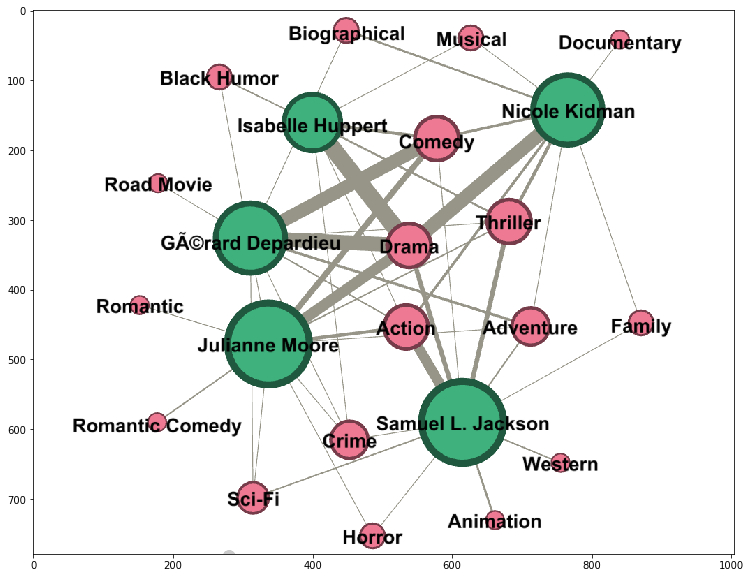

In [5]:
# Read Images
img = mpimg.imread('../Bilder/Schauspieler-Genre.png')
  
# Output Images
plt.imshow(img)
plt.show()

- Interpretation:
    - In den meisten Filmen hat z.B. Gérard Depardieu geschauspielert. Sein Fokus war bei Comedy und Drama. Sein Kollege Samuel L. Jackson hingegen sieht seine Rolle in Action und Thrillers lieber.
    - Alle diese Schauspieler haben mindestens einmal bei den Genres Comedy, Drama, Action und Thriller gespielt.

#### Frage: Welche Filmgenres sind die beliebtesten?
- Filterung: 
    - Hier wird der Durchschnitt der Besucherzahlen pro Genre analysiert.
- Analyse:
    - Diese Analyse geht vor allem nur durch Python, weil wir hier nummerische Spalten haben und dadurch das besser rechnerisch angehen statt grafisch.
- Erwartung:
    - Es wird erwartet, dass Actionfilme die meisten Besucher anlocken, weil es auch nach unseren Vorstellungen die höchsten Kosten verursacht.
- Vorgehen:
    - Hier werden die Genres zuerst gruppiert und zeitgleich alle nummerischen Spalten zusammengenommen und der Durchschnitt ausgerechnet.
    - Dann wird nur noch der Datensatz sortiert und aufgelistet.

In [373]:
df_genre_mean = df_clean.groupby(['Genre']).mean()
df_genre_mean = df_genre_mean[["Besucherzahlen"]]
df_genre_mean = df_genre_mean.sort_values(by=['Besucherzahlen'], ascending=False)
print("Ergebnisse:")
df_genre_mean.head()

Ergebnisse:


,Besucherzahlen
Genre,
Spoof,184120.375000
Fantasy,159081.556962
Animation,116506.423520
Sci-Fi,107253.418605
Teenage,106518.000000


- Interpretation
    - Genre "Spoof" bringt im Durschnitt die meisten Besucher in die Kinosäle. Dies war für uns sehr überraschend. "Spoof" Filme liefen aber in dieser Zeit nicht wirklich viel im Kino. es waren vor allem die Filmreihe "Scary Movie" die dazu beigetragen hat, auf Platz 1 dieser Auflistung zu sein. Obwohl Drama und Comey mit Abstand am meisten produziert wird, werden sie im Schnitt nicht von so vielen Personen angelockt. wahrscheinlich gehts hier darum das diese Filme einfach und günstig zu produzieren sind.

## 4. Ausblick

Es gibt noch viele weitere Schritte, die wir unternehmen können, um genauere Analysen innerhalb der einzelnen Netzwerken durchzuführen. Wir könnten zum Beispiel auch einfache lineare Regression erstellen, um dann die Besucherzahlen vorherzusagen.

Weitere mögliche Analysen wären:

- Knoten anhand eines Attributes zusammenführen
- Modularity-Klasse als Knoten-Labels die Klassennamen angeben
- Group Degree Centrality
- Group Betweenness Centrality

## 5. Lessons Learned

Die von uns gesammelten Daten waren sehr zeitaufwendig zu erheben und zu bereinigen. Vor allem sind wir oft an unseren Grenzen gekommen, als wir mit Gephi versucht haben, die einzelnen Netzwerke zu analysieren. Das Programm hatte oft Schwierigkeiten grosse Datenmengen zu bearbeiten und wir mussten mit viel Wartezeit arbeiten.
Dies war ein grossartiges Projekt, um die Verschiedenen Aspekte der Netzwerkanalyse zu verstehen und verschiedene Programmierfähigkeiten zu vertiefen.

## 6. Quellen

Genutzte Umgebungen: Python & Gephi

Unser GitLab: https://gitlab.fhnw.ch/firat.saritas/filmanalyse

Theorie: SAN Script (https://www.michihenninger.ch/sna-dl/script/SNAScript.pdf)